# AMT Effects of Suggestions

The goal in this notebook is to evaluate the effects of suggestions on the performance of helping the robot recover from errors.

In [1]:
# Reload
%load_ext autoreload
%autoreload 2

In [2]:
# Common imports
import os
import sys
import copy
import time
import datetime
import csv
import json
import re
import pickle
import collections
import pytz

In [3]:
# Data science
import numpy as np
import sklearn
import pandas as pd
import researchpy as rp
import statsmodels.api as sm
import scipy.stats as spstats

from statsmodels.formula import api as smapi
from statsmodels.stats import multicomp

In [4]:
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# Django things
import django
django.setup()
from django.conf import settings
from django.db.models import Q
from django.utils import timezone

In [6]:
# Our stats, display, etc.
from dining_room.stats import data_loader, plotter
from dining_room.stats import stat_tests as stats

In [7]:
# Our models, etc.
from dining_room import constants
from dining_room.models import User, StudyManagement, StudyAction
from dining_room.models.domain import State, Transition, Suggestions

In [9]:
# Get the users, study_conditions, etc that we are analyzing
users = data_loader.load_valid_users()
actions = data_loader.load_valid_actions()
users_df = data_loader.get_users_df()
actions_df = data_loader.get_actions_df()

In [10]:
# We want a particular ordering for the data
study_conditions = [
    User.StudyConditions.BASELINE,
    User.StudyConditions.DX_100,
    User.StudyConditions.AX_100,
    User.StudyConditions.DXAX_100,
    User.StudyConditions.DX_90,
    User.StudyConditions.AX_90,
    User.StudyConditions.DXAX_90,
    User.StudyConditions.DX_80,
    User.StudyConditions.AX_80,
    User.StudyConditions.DXAX_80,
]

start_conditions = list(set([User.StartConditions(x['start_condition'])
                             for x in users.values('start_condition').distinct()]))

# Also setup the display styles
study_conditions_colour_dict = {
    User.StudyConditions.BASELINE: sns.color_palette()[0],
    User.StudyConditions.DX_100: sns.color_palette()[1],
    User.StudyConditions.AX_100: sns.color_palette()[2],
    User.StudyConditions.DXAX_100: sns.color_palette()[3],
    User.StudyConditions.DX_90: sns.color_palette()[1],
    User.StudyConditions.AX_90: sns.color_palette()[2],
    User.StudyConditions.DXAX_90: sns.color_palette()[3],
    User.StudyConditions.DX_80: sns.color_palette()[1],
    User.StudyConditions.AX_80: sns.color_palette()[2],
    User.StudyConditions.DXAX_80: sns.color_palette()[3],
}
study_conditions_hatches_dict = {
    User.StudyConditions.BASELINE: None,
    User.StudyConditions.DX_100: None,
    User.StudyConditions.AX_100: None,
    User.StudyConditions.DXAX_100: None,
    User.StudyConditions.DX_90: '/',
    User.StudyConditions.AX_90: '/',
    User.StudyConditions.DXAX_90: '/',
    User.StudyConditions.DX_80: '.',
    User.StudyConditions.AX_80: '.',
    User.StudyConditions.DXAX_80: '.',
}

In [11]:
# Print out a little summary of stats by study condition
users_value_counts = users_df['study_condition'].value_counts().sort_index()
print("User counts:")
print(users_value_counts.rename(lambda x: User.StudyConditions(x).name))

actions_value_counts = actions_df['study_condition'].value_counts().sort_index()
print("Action counts:")
print(actions_value_counts.rename(lambda x: User.StudyConditions(x).name))

User counts:
BASELINE    20
DX_100      20
AX_100      20
DXAX_100    20
DX_90       20
AX_90       20
DXAX_90     20
DX_80       20
AX_80       20
DXAX_80     20
Name: study_condition, dtype: int64
Action counts:
BASELINE    231
DX_100      247
AX_100      152
DXAX_100    193
DX_90       243
AX_90       217
DXAX_90     183
DX_80       256
AX_80       204
DXAX_80     189
Name: study_condition, dtype: int64


## Demographics

A brief output of demographics data

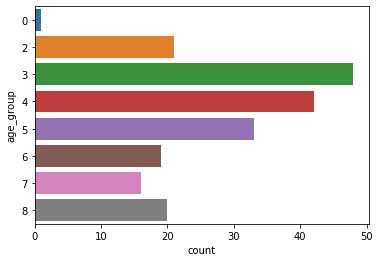

4.0


In [12]:
# Age groups
ax = sns.countplot(y='age_group', data=users_df)
# ax.set_yticklabels([x.name for x in User.AgeGroups])
plt.show()
print(users_df['age_group'].median())

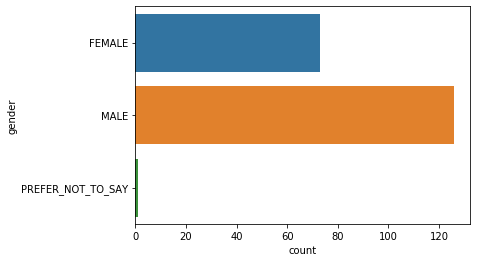

M    126
F     73
U      1
Name: gender, dtype: int64


In [13]:
# Gender
ax = sns.countplot(y='gender', data=users_df)
ax.set_yticklabels([x.name for x in User.Genders])
plt.show()
print(users_df['gender'].value_counts())

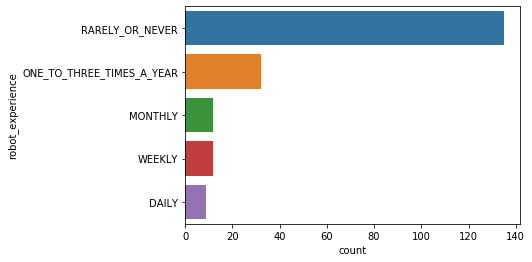

0    135
1     32
3     12
2     12
4      9
Name: robot_experience, dtype: int64


In [15]:
# Robot Experience
ax = sns.countplot(y='robot_experience', data=users_df)
ax.set_yticklabels([x.name for x in User.RobotExperienceGroups])
# ax.legend(labels=[x.name for x in User.StudyConditions])
plt.show()
print(users_df['robot_experience'].value_counts())

## The Survey

Conduct some preliminary analysis of the survey data

In [23]:
# Print the Cronbach's Alpha
_, cronbach_alpha = data_loader.get_survey_df(return_alpha=True)
for k, v in cronbach_alpha.items():
    print(k, f"{v:.3f}")

combo1 0.837
combo3 0.732
combo2 0.724
combo4 0.583
combo5 0.614
combo6 0.507
combo7 0.806
sus 0.940


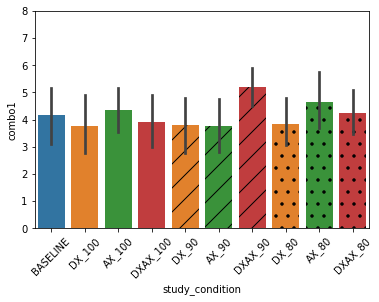

In [25]:
# Diagnosis
survey_df = data_loader.get_survey_df()
variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': study_conditions,
        'labels': [x.name for x in study_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
        'ylim': [0, 8],
    },
]
out_var = 'combo1'  # diagnosis

plotter.plot_data(survey_df, variables_to_plot, out_var)

In [19]:
# Check the significance of diagnosis ~ study_condition
o, r = stats.test_significance(survey_df, 'combo1', 'study_condition')
print(o)



Summary:
                  N  Mean        SD        SE  95% Conf.  Interval  median
study_condition                                                           
1                20  4.15  2.412140  0.539371   3.065369  5.234631     5.0
2                20  3.75  2.510504  0.561366   2.621140  4.878860     2.5
3                20  4.35  1.871532  0.418487   3.508457  5.191543     4.5
4                20  3.90  2.149663  0.480679   2.933393  4.866607     3.5
5                20  3.80  2.483631  0.555357   2.683223  4.916777     3.0
6                20  3.75  2.244877  0.501970   2.740580  4.759420     3.0
7                20  5.20  1.576138  0.352435   4.491282  5.908718     6.0
8                20  3.85  2.058998  0.460406   2.924161  4.775839     3.5
9                20  4.65  2.323224  0.519489   3.605351  5.694649     4.5
10               20  4.25  1.943275  0.434529   3.376197  5.123803     4.5

                            OLS Regression Results                            
Dep. Vari

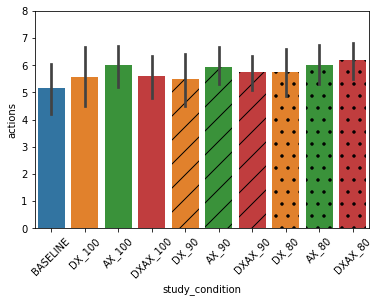

In [20]:
# Actions
variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': study_conditions,
        'labels': [x.name for x in study_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
        'ylim': [0, 8],
    },
]
out_var = 'actions'

plot_data(survey_df, variables_to_plot, out_var)

In [21]:
# Check the significance of actions ~ study_condition
o, r = stats.test_significance(survey_df, 'actions', 'study_condition')
print(o)



Summary:
                  N  Mean        SD        SE  95% Conf.  Interval  median
study_condition                                                           
1                20  5.15  2.230766  0.498814   4.146925  6.153075     6.0
2                20  5.55  2.543826  0.568817   4.406156  6.693844     6.5
3                20  6.00  1.747178  0.390681   5.214373  6.785627     6.0
4                20  5.60  1.846761  0.412948   4.769595  6.430405     6.0
5                20  5.50  2.188487  0.489360   4.515936  6.484064     6.0
6                20  5.95  1.605091  0.358909   5.228263  6.671737     6.0
7                20  5.75  1.482352  0.331464   5.083453  6.416547     6.0
8                20  5.75  2.022895  0.452333   4.840395  6.659605     6.0
9                20  6.00  1.747178  0.390681   5.214373  6.785627     6.0
10               20  6.20  1.542384  0.344887   5.506460  6.893540     6.0

                            OLS Regression Results                            
Dep. Vari

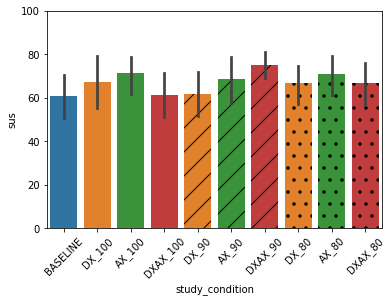

In [22]:
# SUS
variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': study_conditions,
        'labels': [x.name for x in study_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
        'ylim': [0, 100],
    },
]
out_var = 'sus'

plot_data(survey_df, variables_to_plot, out_var)

In [23]:
# Check the significance of sus ~ study_condition
o, r = stats.test_significance(survey_df, 'sus', 'study_condition')
print(o)



Summary:
                  N    Mean         SD        SE  95% Conf.   Interval  median
study_condition                                                               
1                20  60.875  22.988484  5.140381  50.538117  71.211883   67.50
2                20  67.375  30.429762  6.804302  53.692110  81.057890   73.75
3                20  71.250  21.282869  4.758994  61.680055  80.819945   72.50
4                20  61.375  24.122426  5.393938  50.528234  72.221766   67.50
5                20  61.750  25.040756  5.599283  50.490303  73.009697   72.50
6                20  68.500  25.188761  5.632378  57.173752  79.826248   75.00
7                20  75.250  14.997807  3.353612  68.506164  81.993836   76.25
8                20  66.625  19.806216  4.428804  57.719039  75.530961   70.00
9                20  71.125  21.251548  4.751991  61.569139  80.680861   71.25
10               20  66.750  22.464885  5.023301  56.648556  76.851444   73.75

                            OLS Regressi

## The Metrics

The main research question that we're interested in: did people actually benefit from the suggestions?

In [102]:
user_actions_df = users_df.copy()
# actions_df.join(user_actions_df.set_index('pk'), on='user_id')
actions_user_df = actions_df.copy()

In [16]:
# First the difference between optimal & number of actions taken
plot_df = data_loader.get_users_df()
plot_df['num_actions_diff'] = plot_df['num_actions'] - plot_df['num_optimal']

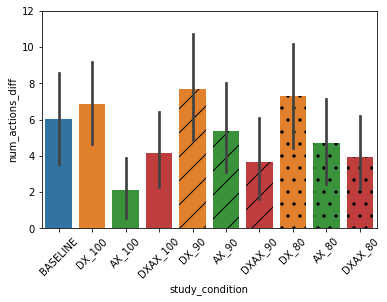

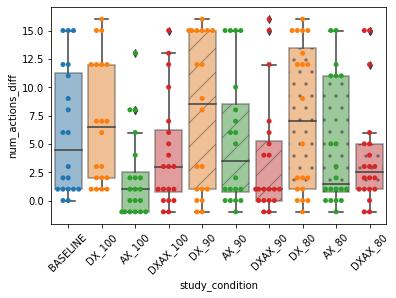

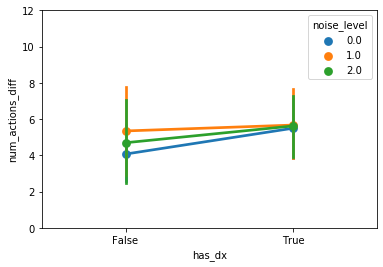

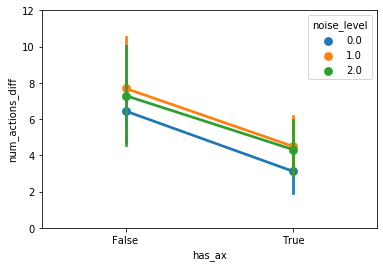

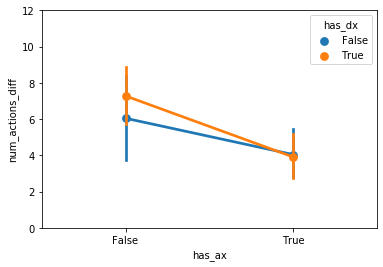

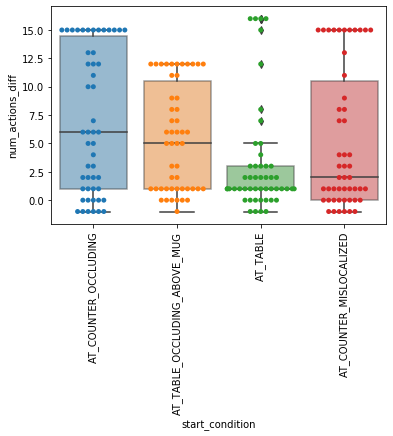

In [21]:
variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': study_conditions,
        'labels': [x.name for x in study_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
        'ylim': [0, 12],
    },
    {
        'var': ('study_condition',),
        'type': 'box',
        'order': study_conditions,
        'labels': [x.name for x in study_conditions],
        'rotation': 45,
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
    },
    { 'var': ('has_dx', 'noise_level'), 'type': 'point', 'ylim': [0, 12], },
    { 'var': ('has_ax', 'noise_level'), 'type': 'point', 'ylim': [0, 12], },
    { 'var': ('has_ax', 'has_dx'), 'type': 'point', 'ylim': [0, 12], },
    {
        'var': ('start_condition',),
        'type': 'box',
        'order': start_conditions,
        'labels': [x.name for x in start_conditions],
        'rotation': 90,
    },
]
out_var = 'num_actions_diff'

plotter.plot_data(plot_df, variables_to_plot, out_var, as_subplots=False)

In [20]:
# Check the significance of num_actions_diff ~ study_condition
o, r = stats.test_significance(plot_df, 'num_actions_diff', 'study_condition', correction_method='fdr_bh')
print(o)



Summary:
                  N  Mean        SD        SE  95% Conf.   Interval  median
study_condition                                                            
1                20  6.05  5.576973  1.247049   3.542287   8.557713     4.5
2                20  6.85  5.431632  1.214550   4.407640   9.292360     6.5
3                20  2.10  3.851179  0.861150   0.368299   3.831701     1.0
4                20  4.15  4.880412  1.091293   1.955499   6.344501     3.0
5                20  7.70  6.790861  1.518483   4.646457  10.753543     8.5
6                20  5.35  5.833434  1.304395   2.726968   7.973032     3.5
7                20  3.65  5.173566  1.156845   1.323681   5.976319     1.0
8                20  7.30  6.538147  1.461974   4.360090  10.239910     7.0
9                20  4.70  5.545031  1.239907   2.206650   7.193350     1.5
10               20  3.95  4.751454  1.062457   1.813486   6.086514     2.5

                            OLS Regression Results                          

In [30]:
# Then the number of people that completed the scenario
plot_df = user_actions_df.groupby(['study_condition', 'scenario_completed']).count()
plot_df['total'] = 20  # Could calculate this, but I don't want to
plot_df = plot_df.reset_index(level=['study_condition', 'scenario_completed'])

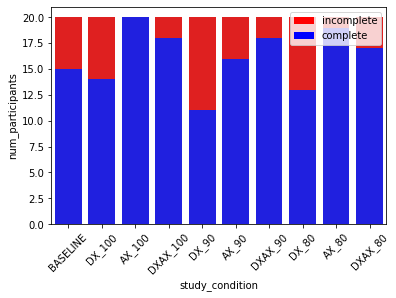

In [31]:
ax = sns.barplot(x='study_condition', y='total', color='red', data=plot_df[plot_df.scenario_completed],
                 order=study_conditions)
ax = sns.barplot(x='study_condition', y='id', color='blue',
                 data=plot_df[plot_df.scenario_completed],
                 order=study_conditions)
ax.set_xticklabels([x.name for x in study_conditions])
ax.set_ylabel('num_participants')
plt.legend([plt.Rectangle((0,0),1,1,fc="red"), plt.Rectangle((0,0),1,1,fc="blue")],
           ['incomplete', 'complete'])
plt.xticks(rotation=45)
plt.show()

In [32]:
# Check the significance of scenario_completed ~ study_condition
plot_df = user_actions_df.loc[:, :].copy()
plot_df['scenario_completed'] = plot_df['scenario_completed'].astype(np.int)
plot_df['has_dx'] = plot_df['has_dx'].astype(np.int)
plot_df['has_ax'] = plot_df['has_ax'].astype(np.int)
plot_df['has_noise'] = plot_df['has_noise'].astype(np.int)

o, r = stats.test_significance(plot_df, 'scenario_completed', 'study_condition',
                               logit_model=False, correction_method='fdr_bh')
print(o)



Summary:
                  N  Mean        SD        SE  95% Conf.  Interval  median
study_condition                                                           
1                20  0.75  0.444262  0.099340   0.550236  0.949764       1
2                20  0.70  0.470162  0.105131   0.488589  0.911411       1
3                20  1.00  0.000000  0.000000   1.000000  1.000000       1
4                20  0.90  0.307794  0.068825   0.761599  1.038401       1
5                20  0.55  0.510418  0.114133   0.320488  0.779512       1
6                20  0.80  0.410391  0.091766   0.615466  0.984534       1
7                20  0.90  0.307794  0.068825   0.761599  1.038401       1
8                20  0.65  0.489360  0.109424   0.429957  0.870043       1
9                20  0.95  0.223607  0.050000   0.849454  1.050546       1
10               20  0.85  0.366348  0.081918   0.685270  1.014730       1

                            OLS Regression Results                            
Dep. Vari

In [33]:
# Get a certainty plot
plot_df = actions_user_df.copy()

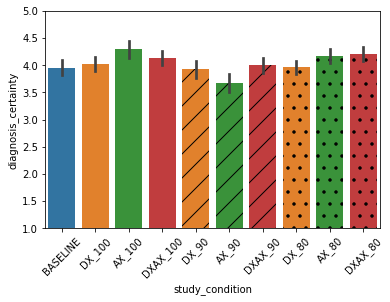

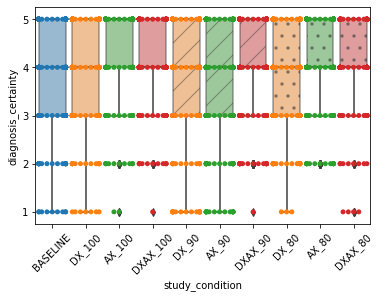

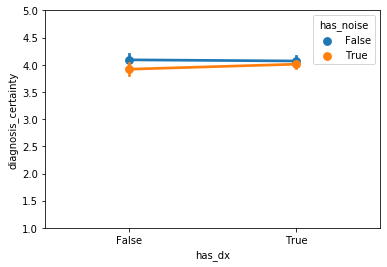

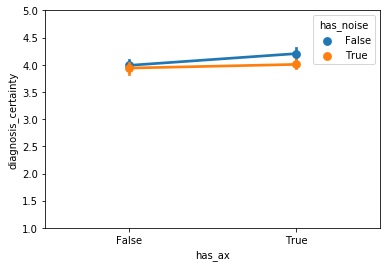

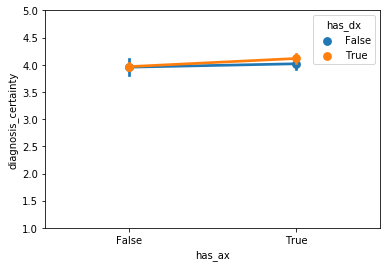

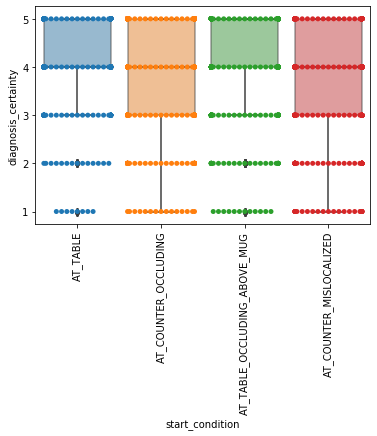

In [34]:
variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': study_conditions,
        'labels': [x.name for x in study_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
        'ylim': [1, 5],
    },
    {
        'var': ('study_condition',),
        'type': 'box',
        'order': study_conditions,
        'labels': [x.name for x in study_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
    },
    { 'var': ('has_dx', 'has_noise'), 'type': 'point', 'ylim': [1, 5], },
    { 'var': ('has_ax', 'has_noise'), 'type': 'point', 'ylim': [1, 5], },
    { 'var': ('has_ax', 'has_dx'), 'type': 'point', 'ylim': [1, 5], },
    {
        'var': ('start_condition',),
        'type': 'box',
        'order': start_conditions,
        'labels': [x.name for x in start_conditions],
        'rotation': 90,
    },
]
out_var = 'diagnosis_certainty'

plot_data(plot_df, variables_to_plot, out_var)

In [35]:
# Check the significance of certainty ~ study_condition
o, r = stats.test_significance(plot_df, 'diagnosis_certainty', 'has_dx', 'has_ax', 'has_noise')
print(o)



Summary:
                           N      Mean        SD        SE  95% Conf.  \
has_dx has_ax has_noise                                                 
False  False  False      231  3.956710  1.129769  0.074333   3.810700   
       True   False      152  4.296053  0.995612  0.080755   4.137250   
              True       421  3.919240  1.149797  0.056038   3.809275   
True   False  False      247  4.020243  1.060945  0.067506   3.887662   
              True       499  3.939880  1.077514  0.048236   3.845242   
       True   False      193  4.134715  0.919968  0.066221   4.004585   
              True       372  4.107527  0.970868  0.050337   4.008733   

                         Interval  median  
has_dx has_ax has_noise                    
False  False  False      4.102720       4  
       True   False      4.454855       5  
              True       4.029204       4  
True   False  False      4.152824       4  
              True       4.034518       4  
       True   False    

In [36]:
# Check the significance of certainty ~ study_condition
o, r = stats.test_significance(plot_df, 'diagnosis_certainty', 'study_condition',
                               correction_method='fdr_bh')
print(o)



Summary:
                   N      Mean        SD        SE  95% Conf.  Interval  \
study_condition                                                           
1                231  3.956710  1.129769  0.074333   3.810700  4.102720   
2                247  4.020243  1.060945  0.067506   3.887662  4.152824   
3                152  4.296053  0.995612  0.080755   4.137250  4.454855   
4                193  4.134715  0.919968  0.066221   4.004585  4.264845   
5                243  3.921811  1.184463  0.075983   3.772576  4.071045   
6                217  3.677419  1.264580  0.085845   3.508774  3.846065   
7                183  4.005464  0.991709  0.073309   3.861384  4.149545   
8                256  3.957031  0.967161  0.060448   3.838322  4.075741   
9                204  4.176471  0.951139  0.066593   4.045627  4.307314   
10               189  4.206349  0.942361  0.068547   4.071641  4.341058   

                 median  
study_condition          
1                     4  
2         

In [37]:
# The time from video start to action selection (including DX and certainty)
plot_df = actions_user_df.copy()

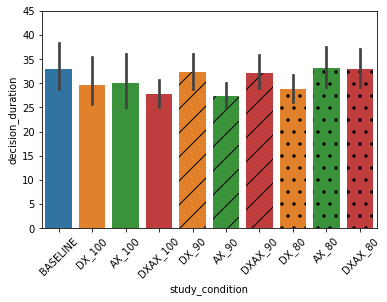

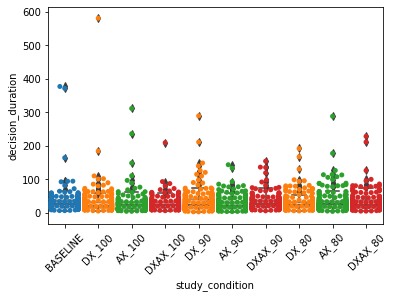

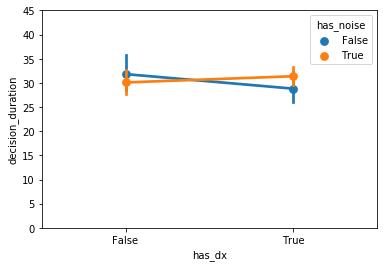

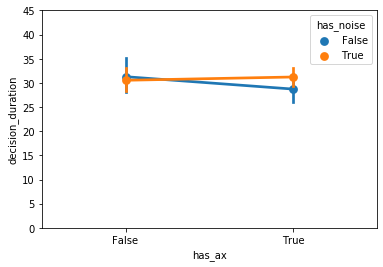

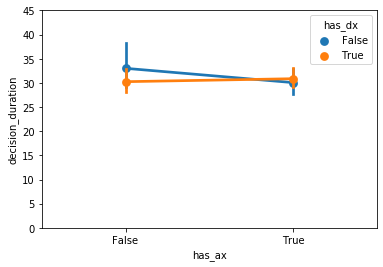

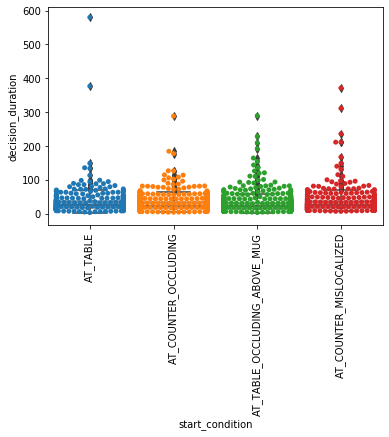

In [38]:
variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': study_conditions,
        'labels': [x.name for x in study_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
        'ylim': [0, 45],
    },
    {
        'var': ('study_condition',),
        'type': 'box',
        'order': study_conditions,
        'labels': [x.name for x in study_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
    },
    { 'var': ('has_dx', 'has_noise'), 'type': 'point', 'ylim': [0, 45], },
    { 'var': ('has_ax', 'has_noise'), 'type': 'point', 'ylim': [0, 45], },
    { 'var': ('has_ax', 'has_dx'), 'type': 'point', 'ylim': [0, 45], },
    {
        'var': ('start_condition',),
        'type': 'box',
        'order': start_conditions,
        'labels': [x.name for x in start_conditions],
        'rotation': 90,
    },
]
out_var = 'decision_duration'

plot_data(plot_df, variables_to_plot, out_var)

In [39]:
# Check the significance of decision_duration ~ study_condition
o, r = stats.test_significance(plot_df, 'decision_duration', 'has_dx', 'has_ax', 'has_noise')
print(o)



Summary:
                           N       Mean         SD        SE  95% Conf.  \
has_dx has_ax has_noise                                                   
False  False  False      231  33.024355  36.606146  2.408508  28.293429   
       True   False      152  30.001724  35.319051  2.864753  24.368245   
              True       421  30.097527  26.286688  1.281135  27.583516   
True   False  False      247  29.672004  40.854654  2.599519  24.566601   
              True       499  30.549603  27.166766  1.216151  28.163554   
       True   False      193  27.730363  20.619156  1.484199  24.813766   
              True       372  32.508011  26.119365  1.354226  29.850153   

                          Interval   median  
has_dx has_ax has_noise                      
False  False  False      37.755281  26.5960  
       True   False      35.635202  22.9845  
              True       32.611539  22.6530  
True   False  False      34.777407  21.4670  
              True       32.935652  2

In [40]:
# Check the significance of decision_duration ~ study_condition
o, r = stats.test_significance(plot_df, 'decision_duration', 'study_condition',
                               correction_method='fdr_bh')
print(o)



Summary:
                   N       Mean         SD        SE  95% Conf.   Interval  \
study_condition                                                              
1                231  33.024355  36.606146  2.408508  28.293429  37.755281   
2                247  29.672004  40.854654  2.599519  24.566601  34.777407   
3                152  30.001724  35.319051  2.864753  24.368245  35.635202   
4                193  27.730363  20.619156  1.484199  24.813766  30.646959   
5                243  32.408366  31.161271  1.998996  28.482246  36.334486   
6                217  27.279949  20.088766  1.363714  24.600889  29.959009   
7                183  32.085541  23.394837  1.729396  28.686625  35.484457   
8                256  28.785230  22.658246  1.416140  26.004158  31.566303   
9                204  33.094657  31.348349  2.194823  28.782220  37.407093   
10               189  32.917069  28.567561  2.077984  28.833402  37.000736   

                  median  
study_condition          

In [41]:
# The time for selecting a diagnosis
plot_df = actions_user_df.copy()

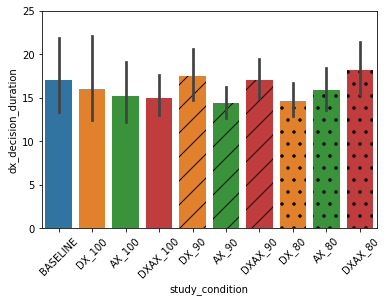

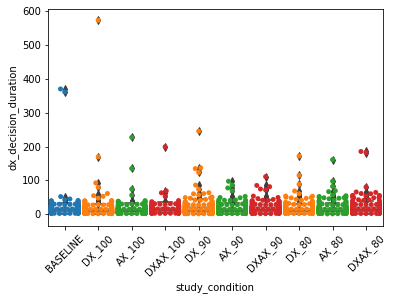

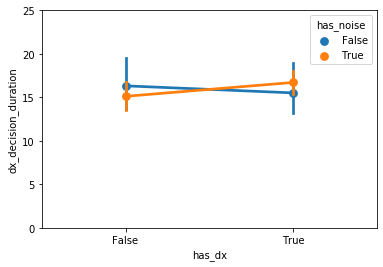

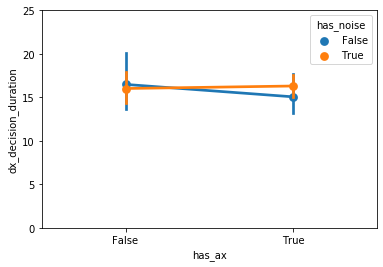

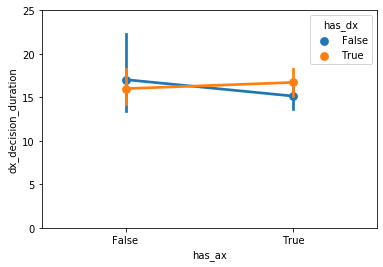

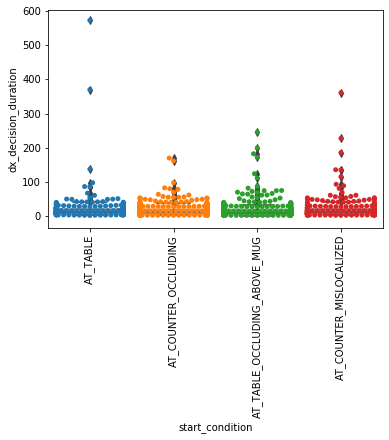

In [42]:
variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': study_conditions,
        'labels': [x.name for x in study_conditions],
        'rotation': 45,
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'ylim': [0, 25],
    },
    {
        'var': ('study_condition',),
        'type': 'box',
        'order': study_conditions,
        'labels': [x.name for x in study_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
    },
    { 'var': ('has_dx', 'has_noise'), 'type': 'point', 'ylim': [0, 25], },
    { 'var': ('has_ax', 'has_noise'), 'type': 'point', 'ylim': [0, 25], },
    { 'var': ('has_ax', 'has_dx'), 'type': 'point', 'ylim': [0, 25], },
    {
        'var': ('start_condition',),
        'type': 'box',
        'order': start_conditions,
        'labels': [x.name for x in start_conditions],
        'rotation': 90,
    },
]
out_var = 'dx_decision_duration'

plot_data(plot_df, variables_to_plot, out_var)

In [43]:
# Check the significance of decision_duration ~ study_condition
o, r = stats.test_significance(plot_df, 'dx_decision_duration', 'has_dx', 'has_ax', 'has_noise')
print(o)



Summary:
                           N       Mean         SD        SE  95% Conf.  \
has_dx has_ax has_noise                                                   
False  False  False      231  17.045221  33.977420  2.235550  12.654027   
       True   False      152  15.248112  22.729836  1.843633  11.622645   
              True       421  15.126033  15.990598  0.779334  13.596721   
True   False  False      247  15.984364  38.805810  2.469155  11.134995   
              True       499  16.025699  20.355744  0.911248  14.237861   
       True   False      193  14.930466  16.719948  1.203528  12.565416   
              True       372  17.657731  19.532741  1.012725  15.670116   

                          Interval  median  
has_dx has_ax has_noise                     
False  False  False      21.436414  11.704  
       True   False      18.873578   9.751  
              True       16.655345  10.741  
True   False  False      20.833734   9.497  
              True       17.813538  10.657 

In [44]:
# Check the significance of decision_duration ~ study_condition
o, r = stats.test_significance(plot_df, 'dx_decision_duration', 'study_condition',
                               correction_method='fdr_bh')
print(o)



Summary:
                   N       Mean         SD        SE  95% Conf.   Interval  \
study_condition                                                              
1                231  17.045221  33.977420  2.235550  12.654027  21.436414   
2                247  15.984364  38.805810  2.469155  11.134995  20.833734   
3                152  15.248112  22.729836  1.843633  11.622645  18.873578   
4                193  14.930466  16.719948  1.203528  12.565416  17.295517   
5                243  17.465053  23.745818  1.523295  14.473233  20.456874   
6                217  14.422230  14.026283  0.952166  12.551670  16.292791   
7                183  17.077328  15.787525  1.167047  14.783639  19.371016   
8                256  14.659437  16.439202  1.027450  12.641691  16.677184   
9                204  15.874686  17.849499  1.249715  13.419219  18.330153   
10               189  18.219709  22.604695  1.644250  14.988420  21.450998   

                 median  
study_condition          


In [45]:
# The time for selecting an action
plot_df = actions_user_df.copy()

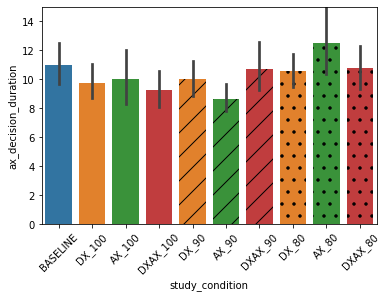

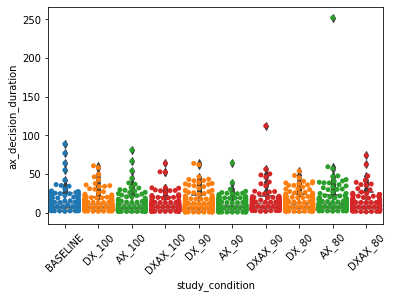

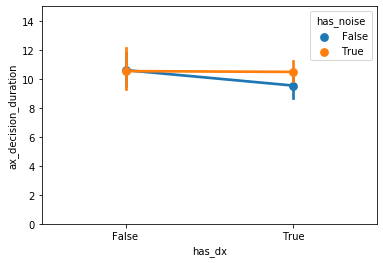

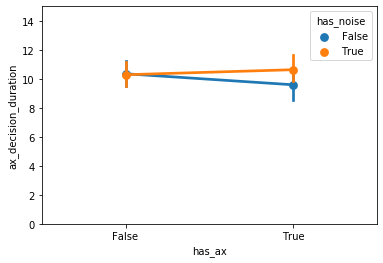

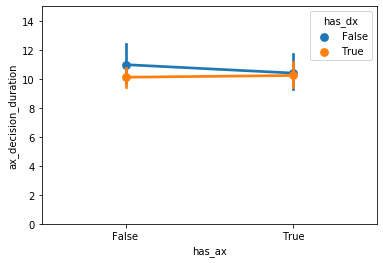

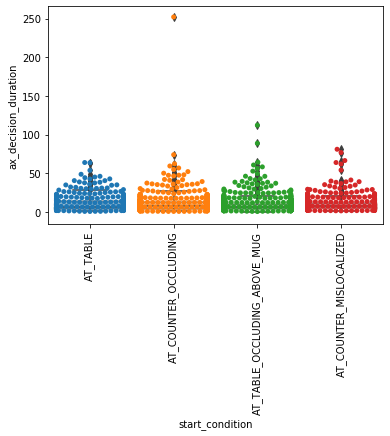

In [46]:
variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': study_conditions,
        'labels': [x.name for x in study_conditions],
        'rotation': 45,
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'ylim': [0, 15],
    },
    {
        'var': ('study_condition',),
        'type': 'box',
        'order': study_conditions,
        'labels': [x.name for x in study_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
    },
    { 'var': ('has_dx', 'has_noise'), 'type': 'point', 'ylim': [0, 15], },
    { 'var': ('has_ax', 'has_noise'), 'type': 'point', 'ylim': [0, 15], },
    { 'var': ('has_ax', 'has_dx'), 'type': 'point', 'ylim': [0, 15], },
    {
        'var': ('start_condition',),
        'type': 'box',
        'order': start_conditions,
        'labels': [x.name for x in start_conditions],
        'rotation': 90,
    },
]
out_var = 'ax_decision_duration'

plot_data(plot_df, variables_to_plot, out_var)

In [47]:
# Check the significance of decision_duration ~ study_condition
o, r = stats.test_significance(plot_df, 'ax_decision_duration', 'has_dx', 'has_ax', 'has_noise')
print(o)



Summary:
                           N       Mean         SD        SE  95% Conf.  \
has_dx has_ax has_noise                                                   
False  False  False      231  10.985706  10.876506  0.715622   9.580041   
       True   False      152  10.033783  11.624528  0.942874   8.179641   
              True       421  10.539114  14.825420  0.722547   9.121237   
True   False  False      247   9.769874   8.978827  0.571309   8.647835   
              True       499  10.290062   9.695823  0.434045   9.438481   
       True   False      193   9.254337   8.826871  0.635372   8.005769   
              True       372  10.747124  10.903674  0.565329   9.637586   

                          Interval  median  
has_dx has_ax has_noise                     
False  False  False      12.391370   7.681  
       True   False      11.887925   6.378  
              True       11.956991   7.243  
True   False  False      10.891914   6.880  
              True       11.141643   7.022 

In [48]:
# Check the significance of decision_duration ~ study_condition
o, r = stats.test_significance(plot_df, 'ax_decision_duration', 'study_condition',
                               correction_method='fdr_bh')
print(o)



Summary:
                   N       Mean         SD        SE  95% Conf.   Interval  \
study_condition                                                              
1                231  10.985706  10.876506  0.715622   9.580041  12.391370   
2                247   9.769874   8.978827  0.571309   8.647835  10.891914   
3                152  10.033783  11.624528  0.942874   8.179641  11.887925   
4                193   9.254337   8.826871  0.635372   8.005769  10.502905   
5                243  10.006177  10.319766  0.662013   8.705953  11.306401   
6                217   8.665834   7.367779  0.500157   7.683259   9.648409   
7                183  10.741230  11.654887  0.861554   9.047951  12.434508   
8                256  10.559531   9.076123  0.567258   9.445528  11.673534   
9                204  12.531770  19.729227  1.381322   9.817718  15.245821   
10               189  10.752831  10.154653  0.738642   9.301247  12.204415   

                 median  
study_condition          


### Diagnosis Suggestions

Can we say anything specific to when diagnosis suggestions were present?

In [103]:
# Focus in on the DX suggestions
plot_df = user_actions_df.copy()
plot_df = plot_df.loc[~plot_df['num_dx_corrupt'].isna(),:]
plot_conditions = [x for x in study_conditions if 'DX' in x.name]

# Add some extra data
plot_df['frac_dx_optimal'] = plot_df['num_dx_optimal'] / plot_df['num_actions']
plot_df['frac_dx_followed'] = plot_df['num_dx_followed'] / plot_df['num_actions']

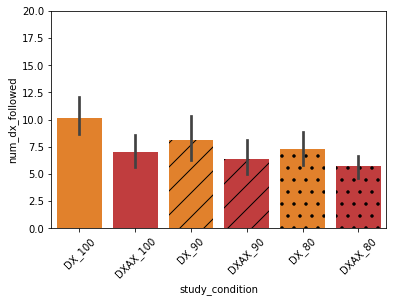

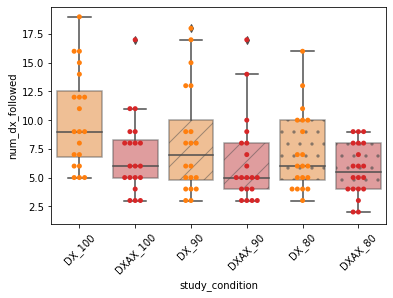

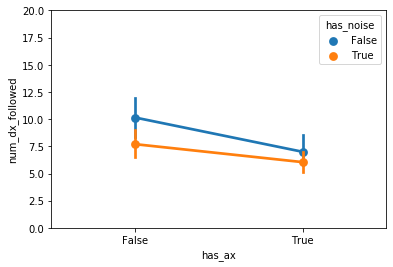

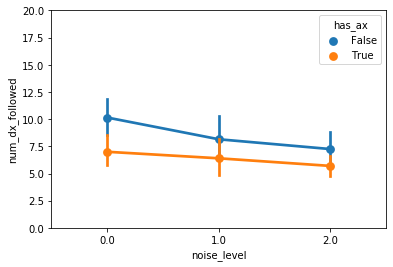

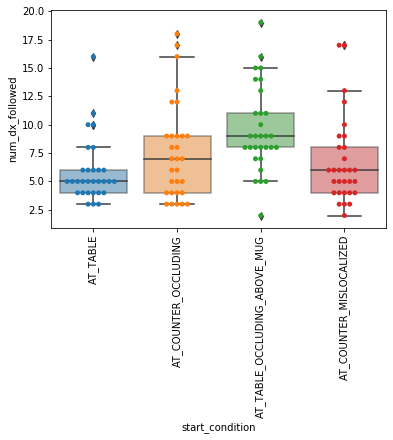

In [105]:
variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
        'ylim': [0, 20],
    },
    {
        'var': ('study_condition',),
        'type': 'box',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
    },
    { 'var': ('has_ax', 'has_noise'), 'type': 'point', 'ylim': [0, 20] },
    { 'var': ('noise_level', 'has_ax'), 'type': 'point', 'ylim': [0, 20] },
    {
        'var': ('start_condition',),
        'type': 'box',
        'order': start_conditions,
        'labels': [x.name for x in start_conditions],
        'rotation': 90,
    },
]
out_var = 'num_dx_followed'

plot_data(plot_df, variables_to_plot, out_var)

In [114]:
# Check the significance of number of diagnosis suggestions followed
# alternatives: has_ax, has_noise, noise_level
o, r = stats.test_significance(plot_df,
                               'num_dx_followed',
                               'study_condition',
#                                'has_ax', 'noise_level',
                               correction_method='fdr_bh')
print(o)



Summary:
                  N   Mean        SD        SE  95% Conf.   Interval  median
study_condition                                                             
2                20  10.15  4.221187  0.943886   8.251923  12.048077     9.0
4                20   7.00  3.402785  0.760886   5.469921   8.530079     6.0
5                20   8.15  4.671019  1.044472   6.049654  10.250346     7.0
7                20   6.40  3.761299  0.841052   4.708714   8.091286     5.0
8                20   7.25  3.477370  0.777564   5.686384   8.813616     6.0
10               20   5.70  2.273416  0.508351   4.677747   6.722253     5.5

                            OLS Regression Results                            
Dep. Variable:        num_dx_followed   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     3.540
Date:                Mon, 24 Feb 2020   Prob (F-statisti

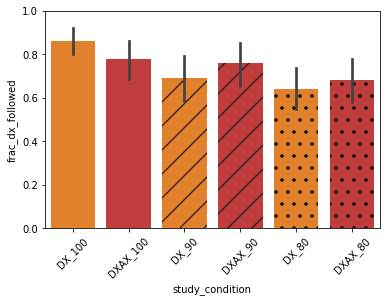

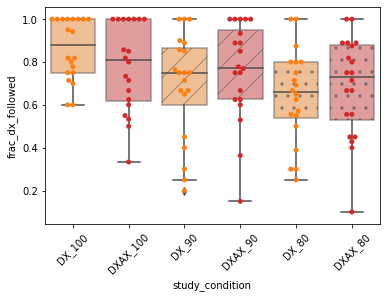

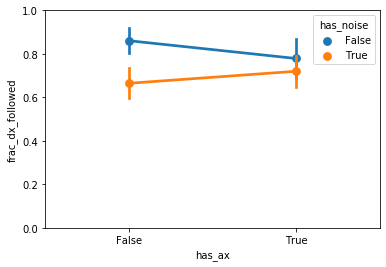

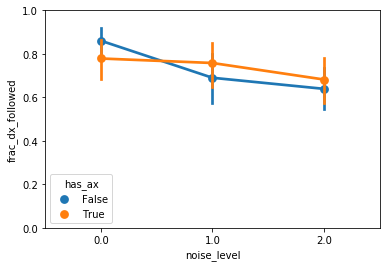

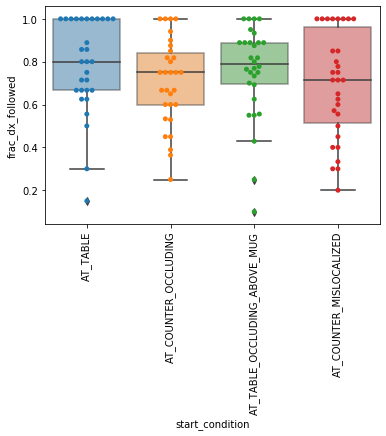

In [110]:
variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
        'ylim': [0, 1],
    },
    {
        'var': ('study_condition',),
        'type': 'box',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
    },
    { 'var': ('has_ax', 'has_noise'), 'type': 'point', 'ylim': [0, 1] },
    { 'var': ('noise_level', 'has_ax'), 'type': 'point', 'ylim': [0, 1] },
    {
        'var': ('start_condition',),
        'type': 'box',
        'order': start_conditions,
        'labels': [x.name for x in start_conditions],
        'rotation': 90,
    },
]
out_var = 'frac_dx_followed'

plot_data(plot_df, variables_to_plot, out_var)

In [115]:
# Check the significance of number of diagnosis suggestions followed
# alternatives: has_ax, has_noise, noise_level
o, r = stats.test_significance(plot_df,
                               'frac_dx_followed',
                               'study_condition',
#                                'has_ax', 'noise_level',
                               correction_method='fdr_bh')
print(o)



Summary:
                  N      Mean        SD        SE  95% Conf.  Interval  \
study_condition                                                          
2                20  0.860980  0.143557  0.032100   0.796429  0.925531   
4                20  0.779064  0.207607  0.046422   0.685712  0.872415   
5                20  0.690418  0.248432  0.055551   0.578709  0.802126   
7                20  0.758392  0.230908  0.051633   0.654563  0.862221   
8                20  0.639457  0.217461  0.048626   0.541674  0.737239   
10               20  0.682358  0.233197  0.052144   0.577500  0.787215   

                   median  
study_condition            
2                0.879679  
4                0.809091  
5                0.750000  
7                0.773504  
8                0.658333  
10               0.732143  

                            OLS Regression Results                            
Dep. Variable:       frac_dx_followed   R-squared:                       0.108
Model:       

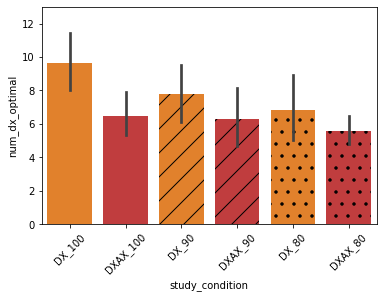

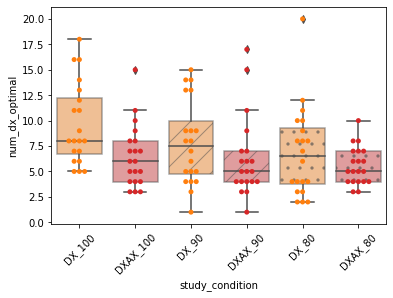

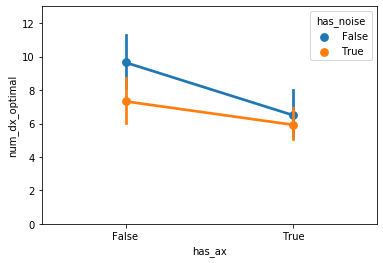

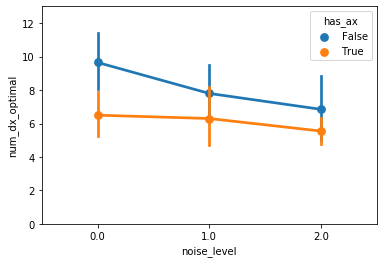

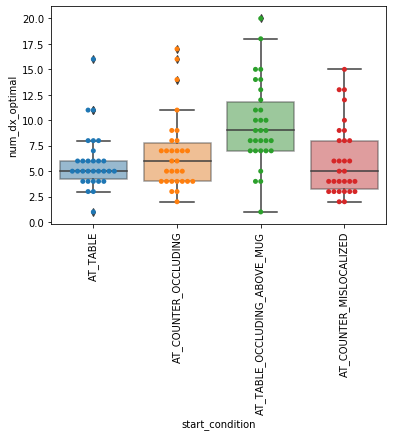

In [117]:
variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
        'ylim': [0, 13],
    },
    {
        'var': ('study_condition',),
        'type': 'box',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
    },
    { 'var': ('has_ax', 'has_noise'), 'type': 'point', 'ylim': [0, 13] },
    { 'var': ('noise_level', 'has_ax'), 'type': 'point', 'ylim': [0, 13] },
    {
        'var': ('start_condition',),
        'type': 'box',
        'order': start_conditions,
        'labels': [x.name for x in start_conditions],
        'rotation': 90,
    },
]
out_var = 'num_dx_optimal'

plot_data(plot_df, variables_to_plot, out_var)

In [118]:
# Check the significance of number of optimal diagnoses picked
o, r = stats.test_significance(plot_df,
                               'num_dx_optimal',
                               'study_condition',
#                                'has_ax', 'noise_level',
                               correction_method='fdr_bh')
print(o)



Summary:
                  N  Mean        SD        SE  95% Conf.   Interval  median
study_condition                                                            
2                20  9.65  4.016741  0.898171   7.843853  11.456147     8.0
4                20  6.50  3.069373  0.686333   5.119841   7.880159     6.0
5                20  7.80  4.149826  0.927929   5.934011   9.665989     7.5
7                20  6.30  3.988140  0.891775   4.506713   8.093287     5.0
8                20  6.85  4.463595  0.998090   4.842923   8.857077     6.5
10               20  5.55  1.848897  0.413426   4.718634   6.381366     5.0

                            OLS Regression Results                            
Dep. Variable:         num_dx_optimal   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     3.060
Date:                Mon, 24 Feb 2020   Prob (F-statistic):     

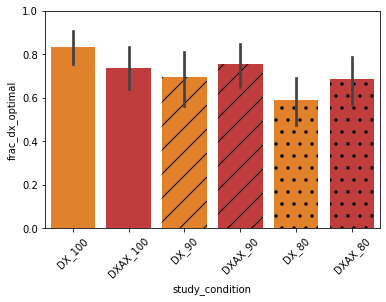

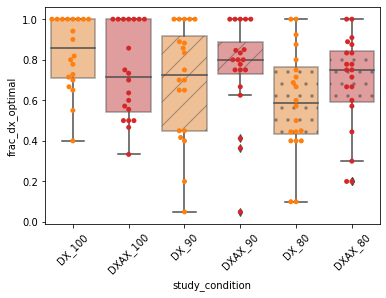

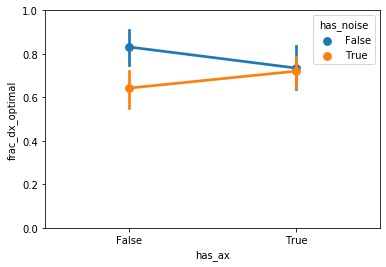

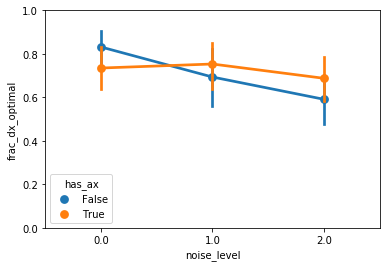

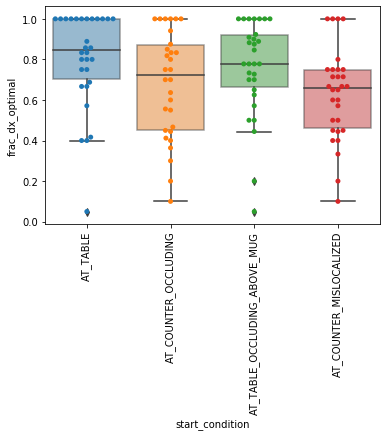

In [119]:
variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
        'ylim': [0, 1],
    },
    {
        'var': ('study_condition',),
        'type': 'box',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
    },
    { 'var': ('has_ax', 'has_noise'), 'type': 'point', 'ylim': [0, 1] },
    { 'var': ('noise_level', 'has_ax'), 'type': 'point', 'ylim': [0, 1] },
    {
        'var': ('start_condition',),
        'type': 'box',
        'order': start_conditions,
        'labels': [x.name for x in start_conditions],
        'rotation': 90,
    },
]
out_var = 'frac_dx_optimal'

plot_data(plot_df, variables_to_plot, out_var)

In [120]:
# Check the significance of number of optimal diagnoses picked
o, r = stats.test_significance(plot_df,
                               'frac_dx_optimal',
                               'study_condition',
#                                'has_ax', 'noise_level',
                               correction_method='fdr_bh')
print(o)



Summary:
                  N      Mean        SD        SE  95% Conf.  Interval  \
study_condition                                                          
2                20  0.832268  0.179963  0.040241   0.751347  0.913189   
4                20  0.735191  0.228711  0.051141   0.632350  0.838032   
5                20  0.693919  0.284322  0.063576   0.566072  0.821766   
7                20  0.753717  0.243109  0.054361   0.644402  0.863032   
8                20  0.591342  0.260352  0.058216   0.474274  0.708411   
10               20  0.687935  0.239960  0.053657   0.580036  0.795834   

                   median  
study_condition            
2                0.859091  
4                0.716667  
5                0.725000  
7                0.800000  
8                0.585714  
10               0.750000  

                            OLS Regression Results                            
Dep. Variable:        frac_dx_optimal   R-squared:                       0.088
Model:       

In [ ]:
# Reset the df so that we can consider all factors
# The number of times ax was selected
plot_df = user_actions_df.copy()

# Add some extra data
plot_df['frac_dx_optimal'] = plot_df['num_dx_optimal'] / plot_df['num_actions']
plot_df['frac_dx_followed'] = plot_df['num_dx_followed'] / plot_df['num_actions']

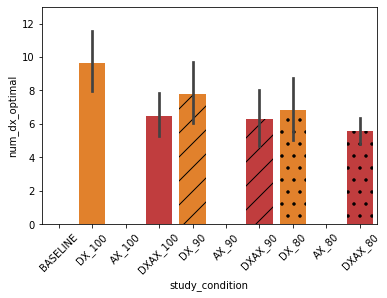

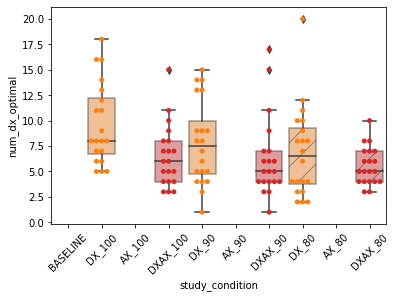

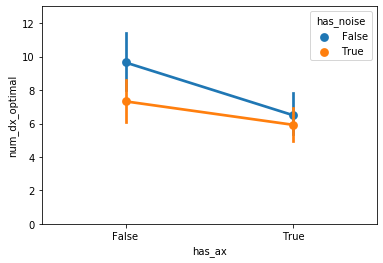

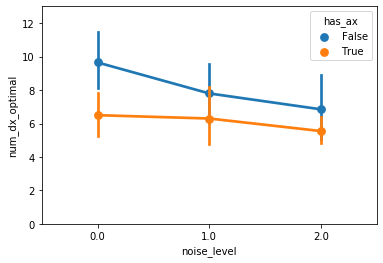

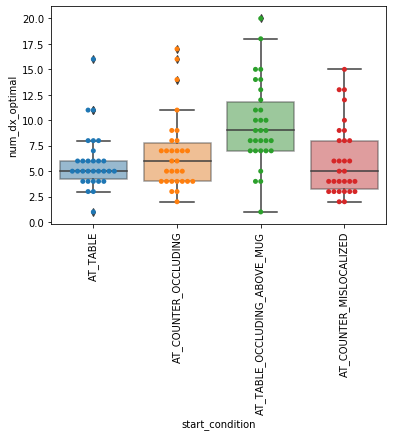

In [121]:
variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': study_conditions,
        'labels': [x.name for x in study_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
        'ylim': [0, 13],
    },
    {
        'var': ('study_condition',),
        'type': 'box',
        'order': study_conditions,
        'labels': [x.name for x in study_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
    },
    { 'var': ('has_ax', 'has_noise'), 'type': 'point', 'ylim': [0, 13] },
    { 'var': ('noise_level', 'has_ax'), 'type': 'point', 'ylim': [0, 13] },
    {
        'var': ('start_condition',),
        'type': 'box',
        'order': start_conditions,
        'labels': [x.name for x in start_conditions],
        'rotation': 90,
    },
]
out_var = 'num_dx_optimal'

plot_data(plot_df, variables_to_plot, out_var)

### Action Suggestions

Can we say anything specific to when action suggestions were present?

In [85]:
# The number of times ax was selected
plot_df = user_actions_df.copy()
plot_df = plot_df.loc[~plot_df['num_ax_corrupt'].isna(),:]
plot_conditions = [x for x in study_conditions if 'AX' in x.name]

# Add some extra data
plot_df['frac_ax_optimal'] = plot_df['num_ax_optimal'] / plot_df['num_actions']
plot_df['frac_ax_followed'] = plot_df['num_ax_followed'] / plot_df['num_actions']

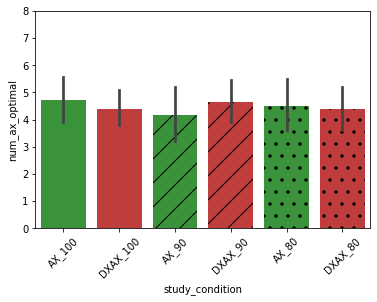

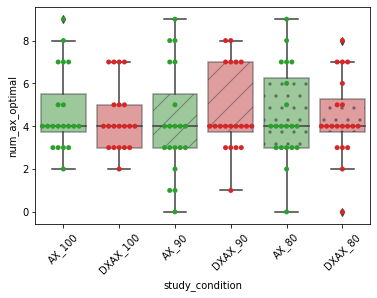

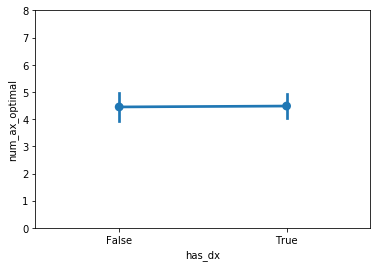

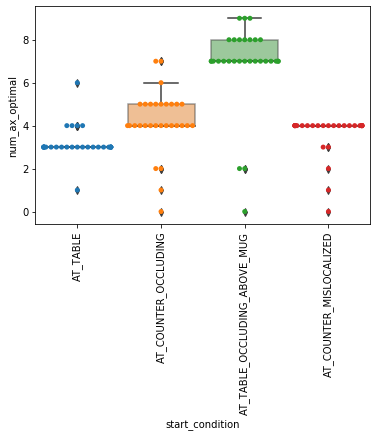

In [61]:
variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
        'ylim': [0, 8],
    },
    {
        'var': ('study_condition',),
        'type': 'box',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
    },
    { 'var': ('has_dx',), 'type': 'point', 'ylim': [0, 8] },
    {
        'var': ('start_condition',),
        'type': 'box',
        'order': start_conditions,
        'labels': [x.name for x in start_conditions],
        'rotation': 90,
    },
]
out_var = 'num_ax_optimal'

plot_data(plot_df, variables_to_plot, out_var)

In [62]:
# Check the significance of number of actions that were deemed optimal for the state
o, r = stats.test_significance(plot_df, 'num_ax_optimal', 'has_dx', 'has_noise',
                               correction_method='bonf')
print(o)



Summary:
                   N   Mean        SD        SE  95% Conf.  Interval  median
has_dx has_noise                                                            
False  False      20  4.700  1.894591  0.423643   3.848088  5.551912       4
       True       40  4.325  2.335759  0.369316   3.591919  5.058081       4
True   False      20  4.400  1.535544  0.343358   3.709535  5.090465       4
       True       40  4.525  1.907979  0.301678   3.926178  5.123822       4

                            OLS Regression Results                            
Dep. Variable:         num_ax_optimal   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.021
Method:                 Least Squares   F-statistic:                    0.1750
Date:                Mon, 24 Feb 2020   Prob (F-statistic):              0.913
Time:                        16:59:24   Log-Likelihood:                -251.90
No. Observations:                 120   AIC:        

In [63]:
# Check the significance of number of actions that were deemed optimal for the state
o, r = stats.test_significance(plot_df, 'num_ax_optimal', 'study_condition',
                               correction_method='bonf')
print(o)



Summary:
                  N  Mean        SD        SE  95% Conf.  Interval  median
study_condition                                                           
3                20  4.70  1.894591  0.423643   3.848088  5.551912       4
4                20  4.40  1.535544  0.343358   3.709535  5.090465       4
6                20  4.15  2.497894  0.558546   3.026810  5.273190       4
7                20  4.65  1.954078  0.436945   3.771339  5.528661       4
9                20  4.50  2.212405  0.494709   3.505181  5.494819       4
10               20  4.40  1.902906  0.425503   3.544349  5.255651       4

                            OLS Regression Results                            
Dep. Variable:         num_ax_optimal   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.035
Method:                 Least Squares   F-statistic:                    0.1941
Date:                Mon, 24 Feb 2020   Prob (F-statistic):             

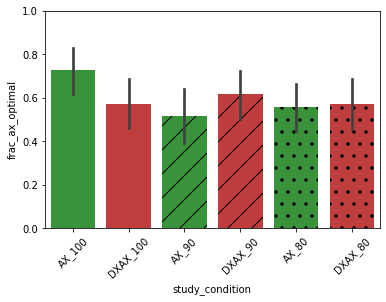

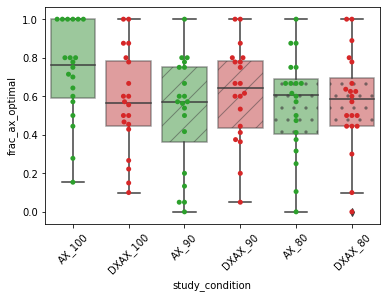

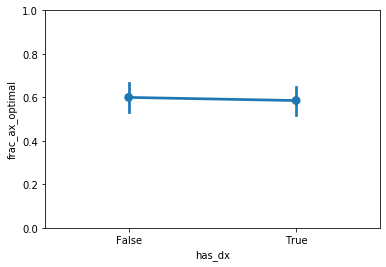

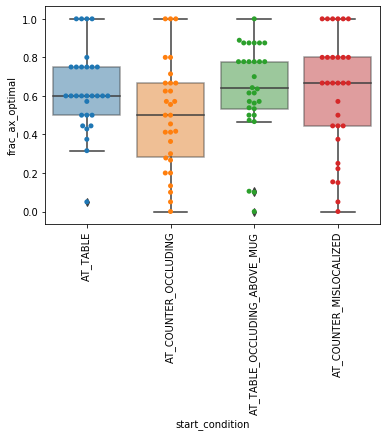

In [64]:
variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
        'ylim': [0, 1],
    },
    {
        'var': ('study_condition',),
        'type': 'box',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
    },
    { 'var': ('has_dx',), 'type': 'point', 'ylim': [0, 1] },
    {
        'var': ('start_condition',),
        'type': 'box',
        'order': start_conditions,
        'labels': [x.name for x in start_conditions],
        'rotation': 90,
    },
]
out_var = 'frac_ax_optimal'

plot_data(plot_df, variables_to_plot, out_var)

In [65]:
# Check the significance of fraction of actions that were deemed optimal for the state
o, r = stats.test_significance(plot_df, 'frac_ax_optimal', 'has_dx', 'has_noise',
                               correction_method='bonf')
print(o)



Summary:
                   N      Mean        SD        SE  95% Conf.  Interval  \
has_dx has_noise                                                          
False  False      20  0.726621  0.248812  0.055636   0.614741  0.838500   
       True       40  0.536831  0.270317  0.042741   0.451992  0.621671   
True   False      20  0.570505  0.264311  0.059102   0.451657  0.689354   
       True       40  0.593298  0.252537  0.039930   0.514039  0.672557   

                    median  
has_dx has_noise            
False  False      0.763889  
       True       0.585714  
True   False      0.563492  
       True       0.607692  

                            OLS Regression Results                            
Dep. Variable:        frac_ax_optimal   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     2.433
Date:                Mon, 24 Feb 2020   Prob (F

In [89]:
# Check the significance of number of actions that were deemed optimal for the state
o, r = stats.test_significance(plot_df, 'frac_ax_optimal', 'study_condition',
                               correction_method='fdr_bh')
print(o)



Summary:
                  N      Mean        SD        SE  95% Conf.  Interval  \
study_condition                                                          
3                20  0.726621  0.248812  0.055636   0.614741  0.838500   
4                20  0.570505  0.264311  0.059102   0.451657  0.689354   
6                20  0.516913  0.288024  0.064404   0.387402  0.646424   
7                20  0.615373  0.251187  0.056167   0.502425  0.728320   
9                20  0.556749  0.257286  0.057531   0.441059  0.672439   
10               20  0.571223  0.258429  0.057786   0.455019  0.687427   

                   median  
study_condition            
3                0.763889  
4                0.563492  
6                0.571429  
7                0.641026  
9                0.607692  
10               0.585714  

                            OLS Regression Results                            
Dep. Variable:        frac_ax_optimal   R-squared:                       0.063
Model:       

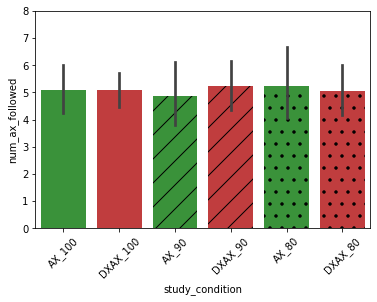

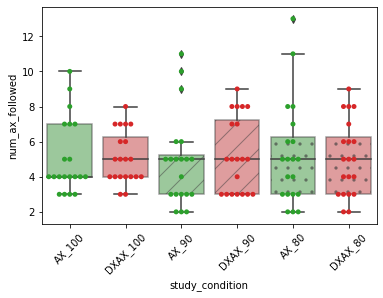

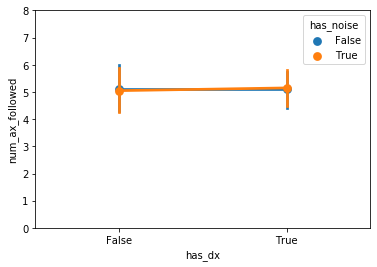

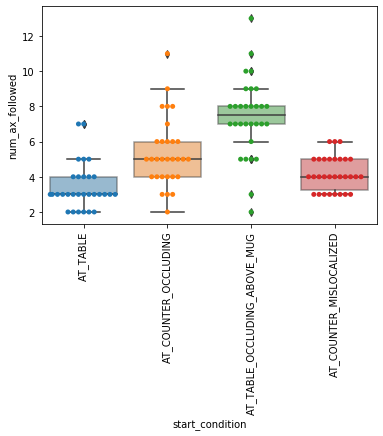

In [67]:
variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
        'ylim': [0, 8],
    },
    {
        'var': ('study_condition',),
        'type': 'box',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
    },
    { 'var': ('has_dx', 'has_noise'), 'type': 'point', 'ylim': [0, 8] },
    {
        'var': ('start_condition',),
        'type': 'box',
        'order': start_conditions,
        'labels': [x.name for x in start_conditions],
        'rotation': 90,
    },
]
out_var = 'num_ax_followed'

plot_data(plot_df, variables_to_plot, out_var)

In [68]:
# Check the significance of number of action suggestions followed
o, r = stats.test_significance(plot_df, 'num_ax_followed', 'has_dx', 'has_noise',
                               correction_method='bonf')
print(o)



Summary:
                   N  Mean        SD        SE  95% Conf.  Interval  median
has_dx has_noise                                                           
False  False      20  5.10  2.125039  0.475173   4.144466  6.055534     4.0
       True       40  5.05  2.754484  0.435522   4.185502  5.914498     5.0
True   False      20  5.10  1.483240  0.331662   4.433054  5.766946     5.0
       True       40  5.15  2.118902  0.335028   4.484980  5.815020     5.0

                            OLS Regression Results                            
Dep. Variable:        num_ax_followed   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.026
Method:                 Least Squares   F-statistic:                   0.01292
Date:                Mon, 24 Feb 2020   Prob (F-statistic):              0.998
Time:                        16:59:26   Log-Likelihood:                -266.70
No. Observations:                 120   AIC:              

In [84]:
# Check the significance of number of action suggestions followed
o, r = stats.test_significance(plot_df, 'num_ax_followed', 'study_condition',
                               correction_method='fdr_bh')
print(o)



Summary:
                  N  Mean        SD        SE  95% Conf.  Interval  median
study_condition                                                           
3                20  5.10  2.125039  0.475173   4.144466  6.055534     4.0
4                20  5.10  1.483240  0.331662   4.433054  5.766946     5.0
6                20  4.85  2.580800  0.577084   3.689531  6.010469     5.0
7                20  5.25  2.149051  0.480542   4.283669  6.216331     5.0
9                20  5.25  2.971354  0.664415   3.913916  6.586084     5.0
10               20  5.05  2.139233  0.478347   4.088084  6.011916     5.0

                            OLS Regression Results                            
Dep. Variable:        num_ax_followed   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.040
Method:                 Least Squares   F-statistic:                   0.08408
Date:                Mon, 24 Feb 2020   Prob (F-statistic):             

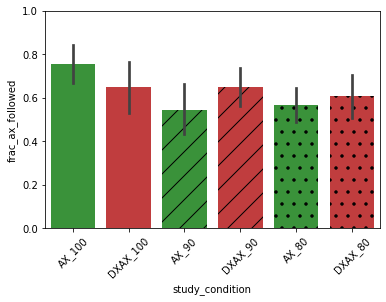

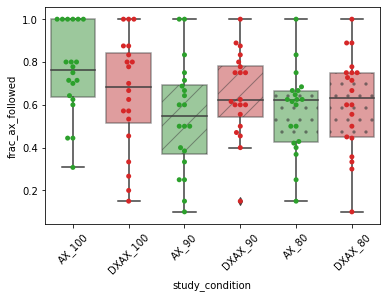

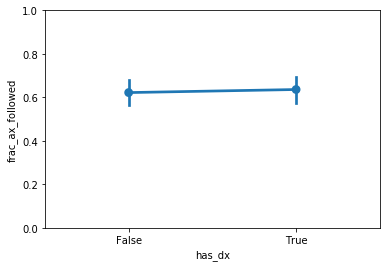

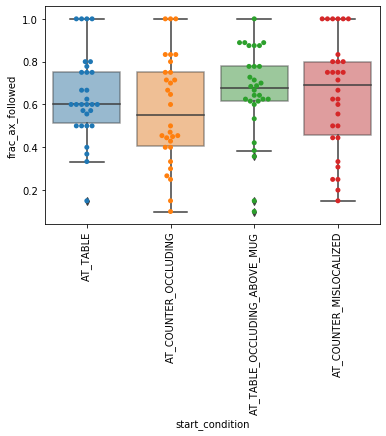

In [87]:
variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
        'ylim': [0, 1],
    },
    {
        'var': ('study_condition',),
        'type': 'box',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
    },
    { 'var': ('has_dx',), 'type': 'point', 'ylim': [0, 1] },
    {
        'var': ('start_condition',),
        'type': 'box',
        'order': start_conditions,
        'labels': [x.name for x in start_conditions],
        'rotation': 90,
    },
]
out_var = 'frac_ax_followed'

plot_data(plot_df, variables_to_plot, out_var)

In [88]:
# Check the significance of fraction of actions that were followed
o, r = stats.test_significance(plot_df, 'frac_ax_optimal', 'study_condition',
                               correction_method='fdr_bh')
print(o)



Summary:
                  N      Mean        SD        SE  95% Conf.  Interval  \
study_condition                                                          
3                20  0.726621  0.248812  0.055636   0.614741  0.838500   
4                20  0.570505  0.264311  0.059102   0.451657  0.689354   
6                20  0.516913  0.288024  0.064404   0.387402  0.646424   
7                20  0.615373  0.251187  0.056167   0.502425  0.728320   
9                20  0.556749  0.257286  0.057531   0.441059  0.672439   
10               20  0.571223  0.258429  0.057786   0.455019  0.687427   

                   median  
study_condition            
3                0.763889  
4                0.563492  
6                0.571429  
7                0.641026  
9                0.607692  
10               0.585714  

                            OLS Regression Results                            
Dep. Variable:        frac_ax_optimal   R-squared:                       0.063
Model:       

## The Domain

Were there idiosyncracies in the domain that might've led to the results we see

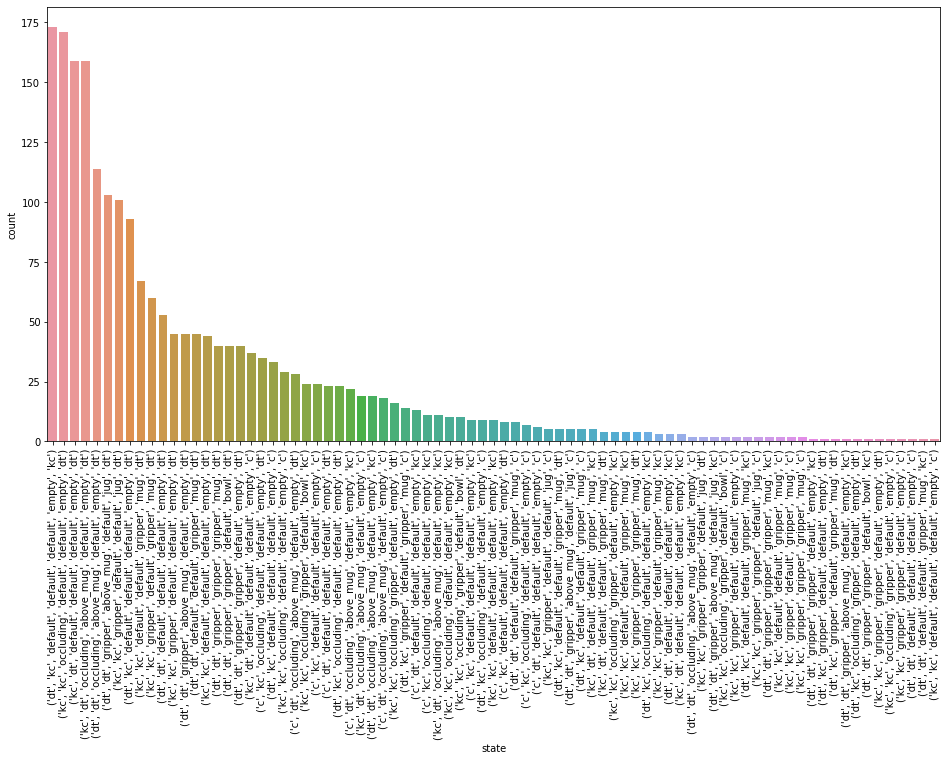

In [71]:
# Histogram of the different states
plot_df = states_df.copy()
fig = plt.figure(figsize=(16, 8))
ax = sns.countplot(x='state', data=plot_df, order=plot_df['state'].value_counts().index)
plt.xticks(rotation=90)
plt.show()

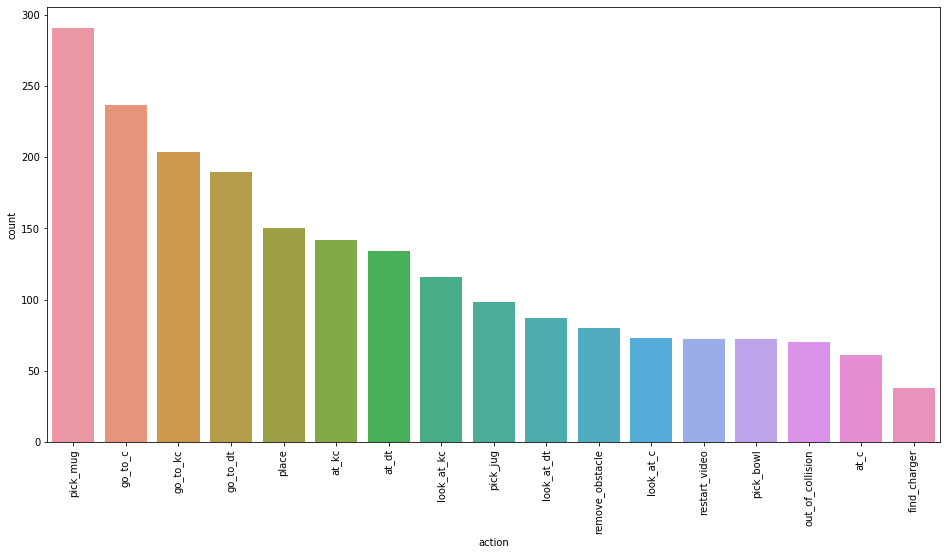

In [72]:
# Histogram of the different actions
plot_df = states_df.copy()
fig = plt.figure(figsize=(16, 8))
ax = sns.countplot(x='action', data=plot_df, order=plot_df['action'].value_counts().index)
plt.xticks(rotation=90)
plt.show()

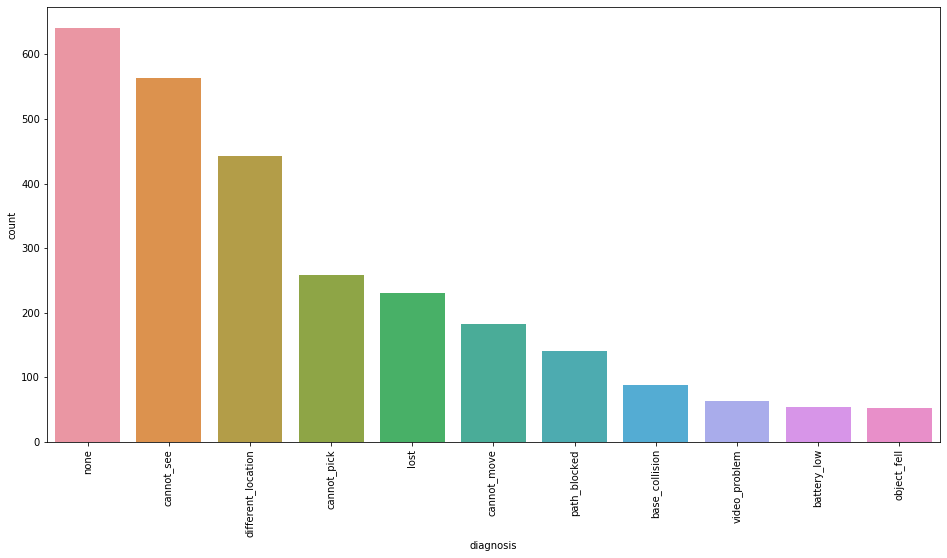

In [94]:
# Histogram of the different diagnoses
plot_df = states_df.copy()
plot_df['id'] = plot_df.index
plot_df = plot_df.melt(
    id_vars=['id', 'study_condition', 'has_ax', 'noise_level', 'has_dx'],
    value_vars=[
        f'{diagnosis}_selected'
        for diagnosis in constants.DIAGNOSES.keys()
    ],
    var_name='diagnosis'
)
plot_df['diagnosis'] = plot_df['diagnosis'].apply(lambda x: x[:-9])
fig = plt.figure(figsize=(16, 8))
ax = sns.countplot(x='diagnosis', data=plot_df.loc[plot_df['value'], :],
                   order=plot_df.loc[plot_df['value'], 'diagnosis'].value_counts().index)
plt.xticks(rotation=90)
plt.show()

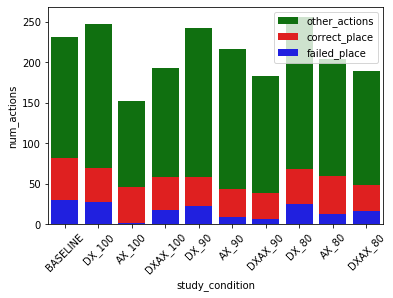

In [80]:
# Counts of the number of failed-to-place actions per condition
plot_df = states_df.copy()
# fig = plt.figure(figsize=(16, 8))
ax = sns.countplot(
    x='study_condition',
    data=plot_df,
    color='green',
    order=study_conditions
)
ax = sns.countplot(
    x='study_condition',
    data=plot_df.loc[~plot_df['failed_to_place'].isna(), :],
    color='red',
    order=study_conditions
)
ax = sns.countplot(
    x='study_condition',
    data=plot_df.loc[~plot_df['failed_to_place'].isna() & plot_df['failed_to_place'], :],
    color='blue',
    order=study_conditions
)
ax.set_xticklabels([x.name for x in study_conditions])
ax.set_ylabel('num_actions')
ax.legend(labels=['other_actions', 'correct_place', 'failed_place'])
plt.xticks(rotation=45)
plt.show()

In [75]:
# Check the significance of failed_to_place ~ study_condition
plot_df = plot_df = states_df.loc[~states_df['failed_to_place'].isna(), :].copy()
plot_df['failed_to_place'] = plot_df['failed_to_place'].astype(np.int)
plot_df['has_dx'] = plot_df['has_dx'].astype(np.int)
plot_df['has_ax'] = plot_df['has_ax'].astype(np.int)
plot_df['has_noise'] = plot_df['has_noise'].astype(np.int)

o, r = stats.test_significance(plot_df, 'failed_to_place', 'study_condition',
                               logit_model=True, correction_method='bonf')
# o, r = stats.test_significance(plot_df, 'failed_to_place', 'has_noise', 'has_ax', 'has_dx',
#                                logit_model=True, correction_method='bonf')
print(o)



Optimization terminated successfully.
         Current function value: 0.567293
         Iterations 8
Summary:
                  N      Mean        SD        SE  95% Conf.  Interval  median
study_condition                                                               
1                82  0.365854  0.484633  0.053519   0.260311  0.471396       0
2                69  0.391304  0.491618  0.059184   0.274454  0.508154       0
3                46  0.021739  0.147442  0.021739  -0.021340  0.064819       0
4                58  0.293103  0.459161  0.060291   0.173901  0.412305       0
5                59  0.389831  0.491898  0.064040   0.263235  0.516426       0
6                44  0.204545  0.408032  0.061513   0.082586  0.326505       0
7                39  0.153846  0.365518  0.058530   0.037628  0.270064       0
8                68  0.367647  0.485750  0.058906   0.251333  0.483961       0
9                60  0.216667  0.415450  0.053634   0.110656  0.322677       0
10               4

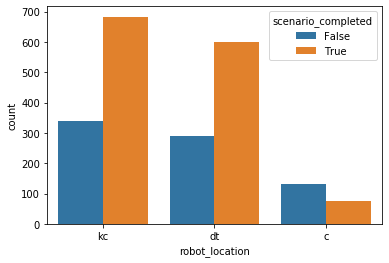

In [76]:
plot_df = states_df.copy()
ax = sns.countplot(x='robot_location', hue='scenario_completed', data=plot_df)
plt.show()

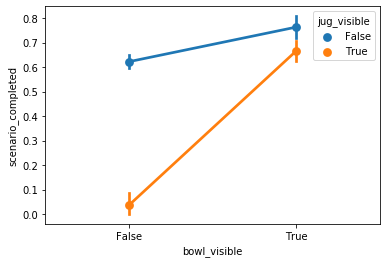

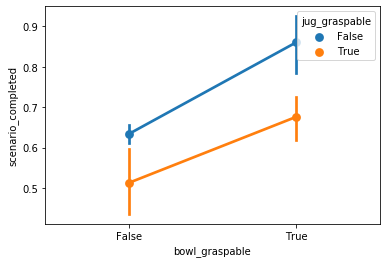

In [77]:
plot_df = states_df.copy()
plot_df['scenario_completed'] = plot_df['scenario_completed'].astype(np.int)
variables_to_plot = [
    {
        'var': ('bowl_visible', 'jug_visible'),
        'type': 'point',
    },
    {
        'var': ('bowl_graspable', 'jug_graspable'),
        'type': 'point',
    },
]
out_var = 'scenario_completed'

plot_data(plot_df, variables_to_plot, out_var)

In [78]:
# Check the time of day isn't messing with our results
plot_df = user_actions_df.copy()
plot_df['tod'] = plot_df['date_demographics_completed']\
                    .apply(lambda x: timezone.localtime(x, pytz.timezone('America/New_York')))\
                    .apply(lambda x: ('morn' if 6 <= x.hour <= 10
                                      else ('noon' if 11 <= x.hour <= 15
                                            else 'evening' if 16 <= x.hour <= 20 else 'night')))
plot_df['num_actions_diff'] = plot_df['num_actions'] - plot_df['num_optimal']

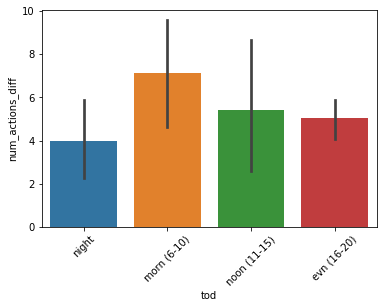

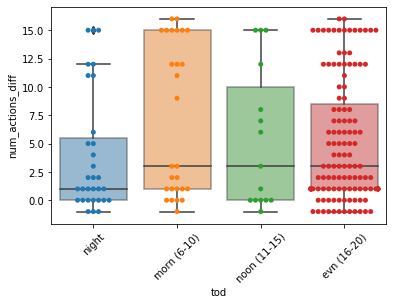

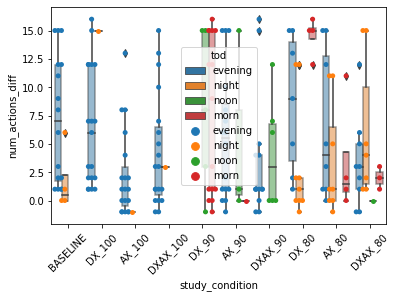

In [79]:
variables_to_plot = [
    {
        'var': ('tod',),
        'type': 'bar',
        'order': ['night', 'morn', 'noon', 'evening'],
        'labels': ['night', 'morn (6-10)', 'noon (11-15)', 'evn (16-20)'],
        'rotation': 45,
    },
    {
        'var': ('tod',),
        'type': 'box',
        'order': ['night', 'morn', 'noon', 'evening'],
        'labels': ['night', 'morn (6-10)', 'noon (11-15)', 'evn (16-20)'],
        'rotation': 45,
    },
    {
        'var': ('study_condition', 'tod'),
        'type': 'box',
        'order': study_conditions,
        'labels': [x.name for x in study_conditions],
        'rotation': 45,
    },
]
out_var = 'num_actions_diff'

plot_data(plot_df, variables_to_plot, out_var, as_subplots=False)